Here you will find four files:<br><font color="#417EAE">humanvsran</font>: contain human 10,000 human sequences and 10,000 random sequences generated by RSAT random-seq.<br><font color="#417EAE">humanvsran_label</font>: labels for <font color="#417EAE">humanvsran</font>, where 1 stands for human sequences and 0 stands for random sequences.<br><font color="#417EAE">predict_seq.py</font>: python code for our CNN.<br><font color="#417EAE">learnseq.ipynb</font>: that's me!



Now lets begin to train our predict_seq program! First import some libraries.

In [82]:
import numpy as np
import torch.utils.data as data_utils
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import pandas as pd

Read our sequence and label file.

In [83]:
dataset = pd.read_csv("datasets/human-exercise/dataset.csv")
print(dataset.shape)
print(dataset.head())

(20000, 2)
                                            sequence  label
0  CTACTCGGGAGGCTGAGGCAGGAGAATCACTTGAACCAGGGAGTCA...      1
1  CACCTTATCCAGAGAAGCTTCTTCTTTTAGAAAATCAAGCAAAACA...      1
2  AAAGGGGCTGATAGAAAAATAAAGAGATTTGGCCAGGTACGGTGGC...      1
3  AAGTGGATATTCAGACCTCCTTGAGGCCTTCGTTGGAAACGGGATT...      1
4  ATACCATGACAAAGATATTATTAGCCAATTTTTAGAGAGAAGGAAA...      1


<AxesSubplot:xlabel='label'>

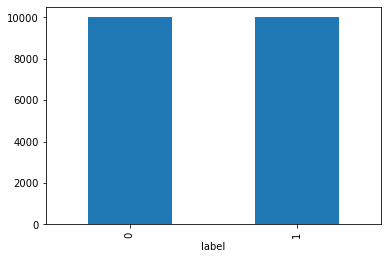

In [84]:
# plot the distribution of each class
dataset.groupby('label').size().plot(kind='bar')

Now we need to one hot encode the sequences and labels.

In [85]:
import encoding as enc

dna_enc = enc.DNAEncoding(dataset)
one_hot_dataset = dna_enc.one_hot_encode() # returns a dataframe
one_hot_dataset

,sequence,label
0,"[[0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [...",1
1,"[[0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...",1
2,"[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...",1
3,"[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...",1
4,"[[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [...",1
...,...,...
19995,"[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...",0
19996,"[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...",0
19997,"[[0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...",0
19998,"[[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [...",0


In [86]:
# split dataset into train and test
train_dataset = one_hot_dataset.sample(frac=0.8, random_state=0)
test_dataset = one_hot_dataset.drop(train_dataset.index)

# separate features (X) and target (y) variables
X_train = np.array(train_dataset['sequence'].to_list())
y_train = np.array(train_dataset['label'].to_list())
X_test = np.array(test_dataset['sequence'].to_list())
y_test = np.array(test_dataset['label'].to_list())

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(16000, 250, 4)
(16000,)
(4000, 250, 4)
(4000,)


In [87]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# convert X and y to torch tensors
train_data = data_utils.TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = data_utils.DataLoader(train_data, shuffle=True, batch_size=4)
test_data = data_utils.TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
test_loader = data_utils.DataLoader(test_data, shuffle=True, batch_size=4)

In [88]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(250, 100)
        self.fc2 = nn.Linear(100, 2)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [89]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [90]:
torch.manual_seed(2022)

learning_rate = 1
gamma = 0.7
epochs = 5

model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
for epoch in range(1,epochs+1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

RuntimeError: Given groups=1, weight of size [20, 4, 10], expected input[4, 250, 4] to have 4 channels, but got 250 channels instead